# Forecasting time series

The task is to predict the exchange rate of the Euro to the US dollar, given past observations on EUR/USD, GBP/USD, and JPY/USD.

In [1]:
# setting logging to print only error messages from Sklearnex
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

from sklearn.metrics import root_mean_squared_error

import warnings
warnings.filterwarnings("ignore")

sns.set_theme(palette="Set2")


def get_mda(y, yhat):
    """Mean Directional Accuracy, as per:
    https://www.wikiwand.com/en/Mean_Directional_Accuracy
    """
    a = np.sign(np.diff(y))
    b = np.sign(np.diff(yhat))
    return np.sum(a == b)/a.shape[0]

# Step 1. Load data

In [2]:
df = pd.read_csv("currencies.csv")

In [3]:
df.head()

,Date,EUR,GBP,JPY
0,07jul2002,1.0274,0.6575,120.21
1,08jul2002,1.0261,0.6570,120.04
2,09jul2002,1.0096,0.6474,118.40
3,10jul2002,1.0065,0.6457,118.06
4,11jul2002,1.0119,0.6463,117.69


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3988 entries, 0 to 3987
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3988 non-null   object 
 1   EUR     3988 non-null   float64
 2   GBP     3988 non-null   float64
 3   JPY     3988 non-null   float64
dtypes: float64(3), object(1)
memory usage: 124.8+ KB


Convert the Date column to datetime:

In [5]:
df['Date'] = pd.to_datetime(df['Date'], format="%d%b%Y")

Set the Date column to be the index in the dataframe:

In [6]:
df.set_index("Date", inplace=True)

In [7]:
df.shape

(3988, 3)

In [8]:
df.index.min(), df.index.max()

(Timestamp('2002-07-07 00:00:00'), Timestamp('2013-06-06 00:00:00'))

There are 3988 daily observations between 07.07.2002 and 06.06.2013.

Check the number of missing values:

In [9]:
df.isnull().sum()

EUR    0
GBP    0
JPY    0
dtype: int64

# Step 2. Train-test split

We will use random sampling, as there is no independent variable to control for.

In [10]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=7, shuffle=False)
train_set.columns = df.columns
test_set.columns = df.columns
print(f"{train_set.shape[0]} train and {test_set.shape[0]} test instances")

3190 train and 798 test instances


In [11]:
train_set

,EUR,GBP,JPY
Date,,,
2002-07-07,1.0274,0.6575,120.2100
2002-07-08,1.0261,0.6570,120.0400
2002-07-09,1.0096,0.6474,118.4000
2002-07-10,1.0065,0.6457,118.0600
2002-07-11,1.0119,0.6463,117.6900
...,...,...,...
2011-03-27,0.7101,0.6236,81.4140
2011-03-28,0.7104,0.6237,81.4199
2011-03-29,0.7110,0.6250,81.6779


In [12]:
test_set

,EUR,GBP,JPY
Date,,,
2011-04-01,0.7057,0.6218,82.8939
2011-04-02,0.7058,0.6229,83.8025
2011-04-03,0.7026,0.6209,84.1084
2011-04-04,0.7026,0.6209,84.1250
2011-04-05,0.7031,0.6198,84.0835
...,...,...,...
2013-06-02,0.7696,0.6582,100.5300
2013-06-03,0.7696,0.6582,100.5300
2013-06-04,0.7678,0.6554,100.1200


# Step 3. Exploratory Data Analysis

Plot the data.

<AxesSubplot:xlabel='Date'>

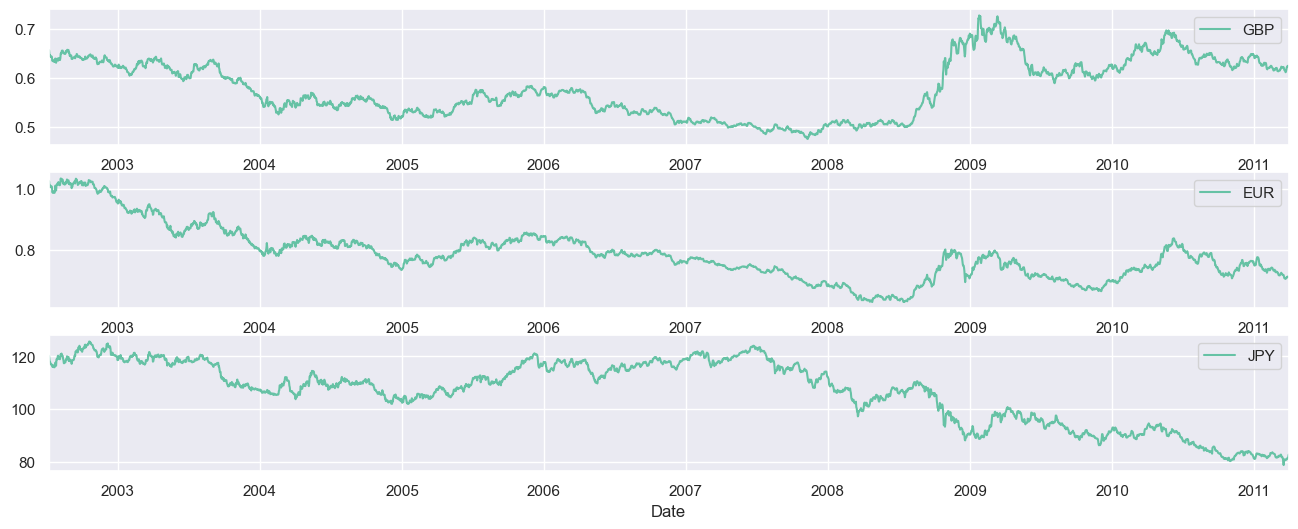

In [13]:
plt.subplot(311)
train_set['GBP'].plot(figsize=(16, 6), legend=True)
plt.subplot(312)
train_set['EUR'].plot(figsize=(16, 6), legend=True)
plt.subplot(313)
train_set['JPY'].plot(figsize=(16, 6), legend=True)

There appears to be no seasonal component, but the behaviour of GBP and EUR seems to be quite similar, suggesting one can contain useful evidence about the other.

# Step 4. Data cleaning and transformation

Before we can build an ARIMA model, we need to ensure the data is **stationary**. We will use the Augmented Dickey-Fuller (ADF) test and the KPSS (Kwiatkowski-Phillips-Schmidt-Shin) tests to test the series for stationarity.

We will conduct the tests only on the training data, determine which transformations are necessary, and apply them on both the training and test data.

First, conduct stationarity tests on the **levels** (i.e., the original, non-transformed data):

In [14]:
from statsmodels.tsa.stattools import adfuller, kpss

for x in ["GBP", "EUR", "JPY"]:
    adf_pval = adfuller(train_set[x], regression="n")[1]
    print(x)
    print(f"ADF, p-value: {adf_pval}")
    kpss_stat, kpss_pval, lags, crit_vals = kpss(train_set[x])
    print(f"KPSS, p-value: {kpss_pval}")

GBP
ADF, p-value: 0.6007292028354361
KPSS, p-value: 0.01
EUR
ADF, p-value: 0.10839784572915939
KPSS, p-value: 0.01
JPY
ADF, p-value: 0.21383376321527658
KPSS, p-value: 0.01


For all the three currencies, the ADF test fails to reject the null of a unit root, and the KPSS test rejects the null of stationarity. I.e., both tests confirm each other's results.

Let's apply some steps to stationarize the series.

## Log-transformation

In [15]:
for x in ["GBP", "EUR", "JPY"]:
    print(x)
    logs = np.log(train_set[x])
    adf_pval = adfuller(logs, regression="n")[1]
    print(f"ADF, p-value: {adf_pval}")
    kpss_stat, kpss_pval, lags, crit_vals = kpss(logs)
    print(f"KPSS, p-value: {kpss_pval}")

GBP
ADF, p-value: 0.6171516511158612
KPSS, p-value: 0.01
EUR
ADF, p-value: 0.7167737899055048
KPSS, p-value: 0.01
JPY
ADF, p-value: 0.21074391388899738
KPSS, p-value: 0.01


After log-transformation, all the three series are still stationary, according to both tests. So we will not use log-transformation.

## Differencing

In [16]:
train_diff = train_set.diff()

In [17]:
train_diff

,EUR,GBP,JPY
Date,,,
2002-07-07,NaN,NaN,NaN
2002-07-08,-0.0013,-0.0005,-0.1700
2002-07-09,-0.0165,-0.0096,-1.6400
2002-07-10,-0.0031,-0.0017,-0.3400
2002-07-11,0.0054,0.0006,-0.3700
...,...,...,...
2011-03-27,0.0031,0.0020,0.2684
2011-03-28,0.0003,0.0001,0.0059
2011-03-29,0.0006,0.0013,0.2580


Differencing produces a missing value at the start of the series, so we will drop it:

In [18]:
train_diff.dropna(inplace=True)

In [19]:
for x in ["GBP", "EUR", "JPY"]:
    print(x)
    adf_pval = adfuller(train_diff[x], regression="n")[1]
    print("ADF, p-value:", adf_pval)
    kpss_stat, kpss_pval, lags, crit_vals = kpss(train_diff[x])
    print("KPSS, p-value:", kpss_pval)

GBP
ADF, p-value: 9.097731414316166e-21
KPSS, p-value: 0.1
EUR
ADF, p-value: 0.0
KPSS, p-value: 0.1
JPY
ADF, p-value: 0.0
KPSS, p-value: 0.1


Both tests indicate that all the three series become stationary after first-differencing: the ADF test rejects the null of unit root, and the KPSS test fails to reject the null of stationarity, at the 0.05 significance level.

Let's plot the differenced training data:

<AxesSubplot:xlabel='Date'>

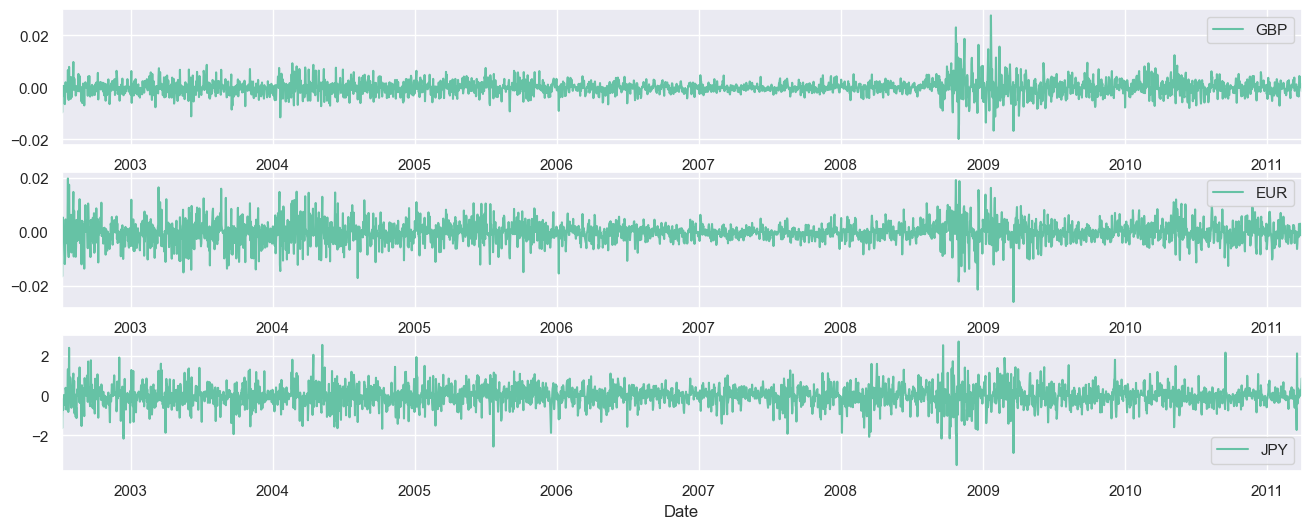

In [20]:
plt.subplot(311)
train_diff['GBP'].plot(figsize=(16, 6), legend=True)
plt.subplot(312)
train_diff['EUR'].plot(figsize=(16, 6), legend=True)
plt.subplot(313)
train_diff['JPY'].plot(figsize=(16, 6), legend=True)

Apply first-differencing to the test data too:

In [21]:
test_diff = test_set.diff().dropna()

# Step 5. Build and evaluate models

## Baselines

We will create two baselines: (1) a persistence baseline and (2) a mean baseline.

### Persistence baseline

The first five observations are:

In [22]:
test_diff['EUR'].head()

Date
2011-04-02    0.0001
2011-04-03   -0.0032
2011-04-04    0.0000
2011-04-05    0.0005
2011-04-06    0.0011
Name: EUR, dtype: float64

The `shift()` method creates a new series with values shifted one day ahead:

In [23]:
test_diff['EUR'].shift().head()

Date
2011-04-02       NaN
2011-04-03    0.0001
2011-04-04   -0.0032
2011-04-05    0.0000
2011-04-06    0.0005
Name: EUR, dtype: float64

So we will use latter as forecasts of the former. Because `shift()` creates a missing value for the first day, we will drop the first observation in both series, and then calculate an RMSE score:

In [24]:
y = test_diff['EUR'][1:]
yhat = test_diff['EUR'].shift()[1:]

pers_baseline_rmse = root_mean_squared_error(y, yhat)
pers_baseline_rmse

0.0036332685977666945

In [25]:
pers_baseline_mda = get_mda(y, yhat)
pers_baseline_mda

0.38742138364779877

### Mean baseline

The mean baseline calculates the mean of the series in the training data and predicts the value for each test observation.

In [26]:
train_diff_mean = train_diff['EUR'].mean()
train_diff_mean

-9.97491376607087e-05

In [27]:
y = test_diff['EUR']
yhat = [train_diff_mean]*test_diff.shape[0]

mean_baseline_rmse = root_mean_squared_error(y, yhat)
mean_baseline_rmse

0.003045184725786605

In [28]:
mean_baseline_mda = get_mda(y, yhat)
mean_baseline_mda

0.010050251256281407

## Machine Learning methods

To be able to input the time series into the scikit-learn implementation of machine learning algorthms, the data needs to be arranged into a format where rows contain instances and columns contain different lagged values of both the endogenous variable and exogenous variables.

As input, the function `create_ar_vars` takes:

(1) a one-dimensional array representing the endogenous variable;

(2) a two-dimensional array representing the exogenous variable(s);

(3) the number of lags.

It outputs:

(1) a two dimensional numpy array containing predictor variables and 

(2) a one-dimensional array containing the target variable.

In [29]:
def create_ar_vars(endog, exog, lags=2):
    """Create autoregressive variables from endogenous and exogenous
    variables
    """
    X, y = [], []
    for i in range(len(endog)-lags):
        endog_row = endog[i:i + lags, 0]
        exog_row = exog[i:i + lags,:].flatten()
        X.append(np.concatenate([endog_row, exog_row]))
        y.append(endog[i + lags, 0])
    return np.array(X), np.array(y)

Below is an example input and example output:

In [30]:
a = np.array([[1],[2],[3],[4],[5],[6],[7],[8],[9],[10],[11],[12]])
b = np.array([[10, 100],[20, 200],[30, 300],[40, 400],[50, 500],[60, 600],
              [70, 700],[80, 800],[90, 900],[100, 1000],[110, 1100],[120, 1200]])
print(f"Input endogs:\n{a}")
print(f"Input exogs:\n{b}")
Xexample, yexample = create_ar_vars(a, b, lags=2)
print("Output:")
np.hstack((Xexample, yexample.reshape(-1, 1)))

Input endogs:
[[ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]]
Input exogs:
[[  10  100]
 [  20  200]
 [  30  300]
 [  40  400]
 [  50  500]
 [  60  600]
 [  70  700]
 [  80  800]
 [  90  900]
 [ 100 1000]
 [ 110 1100]
 [ 120 1200]]
Output:


array([[   1,    2,   10,  100,   20,  200,    3],
       [   2,    3,   20,  200,   30,  300,    4],
       [   3,    4,   30,  300,   40,  400,    5],
       [   4,    5,   40,  400,   50,  500,    6],
       [   5,    6,   50,  500,   60,  600,    7],
       [   6,    7,   60,  600,   70,  700,    8],
       [   7,    8,   70,  700,   80,  800,    9],
       [   8,    9,   80,  800,   90,  900,   10],
       [   9,   10,   90,  900,  100, 1000,   11],
       [  10,   11,  100, 1000,  110, 1100,   12]])

Let's create the predictor variables and the target variables for both training and test sets.

In [31]:
Xtrain, ytrain = create_ar_vars(endog=train_diff["EUR"].values.reshape(-1, 1), 
                                exog=train_diff[["GBP", "JPY"]].values,
                                lags=5)
Xtest, ytest = create_ar_vars(endog=test_diff["EUR"].values.reshape(-1, 1),
                              exog=test_diff[["GBP", "JPY"]].values,
                              lags=5)

As usual, the predictor variables need to be scaled:

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

In order to tune hyperparameters for a time-series model, we cannot use the usual cross-validation technique. Instead, we should create folds in a way that training data always precedes the validation data. In scikit-learn, this is implemented in the `TimeSeriesSplit` class.

Here is an illustration how the training-validation splits are created from the full training set. The code below creates five different splits and prints out the total number of observations used in a split and the sizes of the training and validation sets. The two sets are also plotted for each of the five splits.

Full training set size: 3184

Split 1
Observations: 1064
Training Observations: 534
Validation Observations: 530
Split 2
Observations: 1594
Training Observations: 1064
Validation Observations: 530
Split 3
Observations: 2124
Training Observations: 1594
Validation Observations: 530
Split 4
Observations: 2654
Training Observations: 2124
Validation Observations: 530
Split 5
Observations: 3184
Training Observations: 2654
Validation Observations: 530


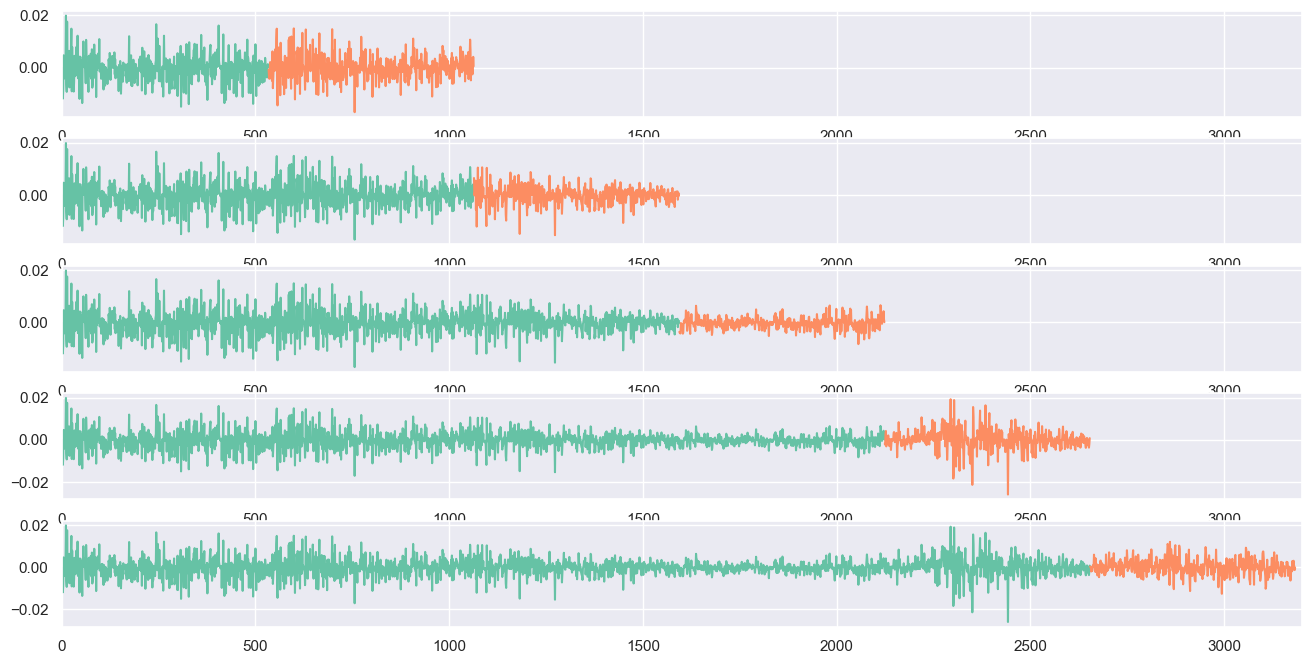

In [33]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

tscv = TimeSeriesSplit(n_splits=5)
plt.figure(figsize=(16, 8))
plt.figure(1)
print(f"Full training set size: {Xtrain.shape[0]}\n")
index = 1
for train_index, test_index in tscv.split(Xtrain):
    train = ytrain[train_index]
    test = ytrain[test_index]
    obs = len(train) + len(test)
    print(f'Split {index}')
    print(f'Observations: {obs}')
    print(f'Training Observations: {len(train)}')
    print(f'Validation Observations: {len(test)}')
    ax = plt.subplot(510 + index)
    plt.plot(train)
    plt.plot([None for i in train] + 
                 [x for x in test] + 
                 [None for i in range(obs, Xtrain.shape[0])])
    ax.set_xlim([0, 3200])
    index += 1

More information on `TimeSeriesSplit` can be found in the scikit-learn [User Guide](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).

Once the validation splits have been created, we can siupply the `TimeSeriesSplit` object to the grid search tool and run it to find the best hyperparameter settings in the usual way. The code below shows an example of a Random Forest regression model trained on the data.

### Random Forest

In [34]:
%%time

from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=7)
param_grid = [
    {'n_estimators': [2, 3, 5, 10, 20, 50], 
     'max_depth': [2, 4, 6, 8, None]},
]

tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=forest_reg, cv=tscv,
                        param_grid=param_grid,
                        scoring='neg_root_mean_squared_error', 
                        return_train_score=True)
grid_search.fit(Xtrain, ytrain)

CPU times: total: 24.8 s
Wall time: 25 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=7),
             param_grid=[{'max_depth': [2, 4, 6, 8, None],
                          'n_estimators': [2, 3, 5, 10, 20, 50]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [35]:
-grid_search.best_score_

0.0036028873396012004

In [36]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 
                                                    'mean_test_score']]
cv_results["mean_train_score"] = -cv_results["mean_train_score"]
cv_results["mean_test_score"] = -cv_results["mean_test_score"]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

cv_results.sort_values('mean_test_score')

,params,mean_train_score,mean_test_score,"diff, %"
5,"{'max_depth': 2, 'n_estimators': 50}",0.004203,0.003603,14.283256
4,"{'max_depth': 2, 'n_estimators': 20}",0.004202,0.003603,14.247907
3,"{'max_depth': 2, 'n_estimators': 10}",0.004206,0.003608,14.202791
2,"{'max_depth': 2, 'n_estimators': 5}",0.004214,0.003610,14.329804
11,"{'max_depth': 4, 'n_estimators': 50}",0.004037,0.003616,10.424318
10,"{'max_depth': 4, 'n_estimators': 20}",0.004034,0.003621,10.215727
1,"{'max_depth': 2, 'n_estimators': 3}",0.004227,0.003627,14.210890
17,"{'max_depth': 6, 'n_estimators': 50}",0.003784,0.003636,3.904628
9,"{'max_depth': 4, 'n_estimators': 10}",0.004039,0.003640,9.889196
0,"{'max_depth': 2, 'n_estimators': 2}",0.004239,0.003648,13.931576


### Support Vector Regression with the RBF kernel

In [37]:
%%time

from sklearn.svm import SVR

svr = SVR(kernel="rbf")
param_grid = [
        {
            "C": [0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 5.0],
            "epsilon": [0.001, 0.01],
            "gamma": [0.0001, 0.001, 0.01, 0.1, "scale", "auto"]
        }
]

tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=svr, cv=tscv,
                        param_grid=param_grid,
                        scoring='neg_root_mean_squared_error', 
                        return_train_score=True)
grid_search.fit(Xtrain, ytrain)

CPU times: total: 1min 55s
Wall time: 1min 56s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=SVR(),
             param_grid=[{'C': [0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 5.0],
                          'epsilon': [0.001, 0.01],
                          'gamma': [0.0001, 0.001, 0.01, 0.1, 'scale',
                                    'auto']}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [38]:
-grid_search.best_score_

0.003574385325694851

In [39]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["mean_train_score"] = -cv_results["mean_train_score"]
cv_results["mean_test_score"] = -cv_results["mean_test_score"]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

cv_results.sort_values('mean_test_score')

,params,mean_train_score,mean_test_score,"diff, %"
3,"{'C': 0.001, 'epsilon': 0.001, 'gamma': 0.1}",0.003995,0.003574,10.522921
22,"{'C': 0.005, 'epsilon': 0.01, 'gamma': 'scale'}",0.004200,0.003577,14.851804
9,"{'C': 0.001, 'epsilon': 0.01, 'gamma': 0.1}",0.004236,0.003578,15.527205
10,"{'C': 0.001, 'epsilon': 0.01, 'gamma': 'scale'}",0.004253,0.003579,15.853377
11,"{'C': 0.001, 'epsilon': 0.01, 'gamma': 'auto'}",0.004252,0.003579,15.816294
...,...,...,...,...
64,"{'C': 1.0, 'epsilon': 0.001, 'gamma': 'scale'}",0.001334,0.005687,-326.410512
65,"{'C': 1.0, 'epsilon': 0.001, 'gamma': 'auto'}",0.001323,0.005719,-332.210577
75,"{'C': 5.0, 'epsilon': 0.001, 'gamma': 0.1}",0.001081,0.005909,-446.507764
76,"{'C': 5.0, 'epsilon': 0.001, 'gamma': 'scale'}",0.001131,0.006661,-489.092119


There are no obvious signs of overfitting.

### Evaluate the best SVR model on the test data

In [40]:
best_model = grid_search.best_estimator_

yhat = best_model.predict(Xtest)

svr_rmse = root_mean_squared_error(ytest, yhat)
svr_rmse

0.00297231921585247

In [41]:
svr_mda = get_mda(ytest, yhat)
svr_mda

0.43236409608091025

Let's plot the forecasted values.

<AxesSubplot:>

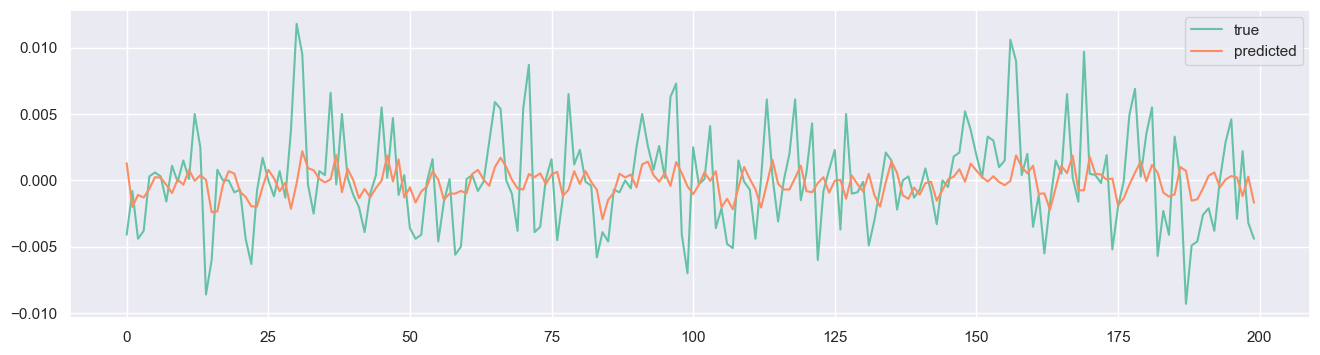

In [42]:
pd.DataFrame({"true": ytest[:200], "predicted": yhat[:200]}).plot(figsize=(16, 4))

# Summary

## RMSE results

In [43]:
rmse_table = pd.DataFrame({
    'method': ['Persistence baseline', 'Mean baseline', 'SVR'],
    'RMSE': [pers_baseline_rmse, mean_baseline_rmse, svr_rmse],
})

rmse_table.set_index("method", inplace=True)

# add columns with percent changes on the baselines
rmse_table['% Change on Pers. baseline'] = 100 * rmse_table['RMSE'] / pers_baseline_rmse - 100
rmse_table['% Change on Mean baseline'] = 100 * rmse_table['RMSE'] / mean_baseline_rmse - 100

rmse_table

,RMSE,% Change on Pers. baseline,% Change on Mean baseline
method,,,
Persistence baseline,0.003633,0.000000,19.311928
Mean baseline,0.003045,-16.186083,0.000000
SVR,0.002972,-18.191592,-2.392811


In terms of RMSE, SVR produced an 18\% RMSE reduction on the persistence baseline and 2.3\% reduction on the mean baseline.

## MDA results

In [45]:
mda_table = pd.DataFrame({
    'method': ['Persistence baseline', 'Mean baseline', 'SVR'],
    'MDA': [pers_baseline_mda, mean_baseline_mda, svr_mda]
})

mda_table.set_index("method", inplace=True)

# add columns with percent changes on the baselines
mda_table['% Change on Pers. baseline'] = 100 * mda_table['MDA'] / pers_baseline_mda - 100
mda_table['% Change on Mean baseline'] = 100 * mda_table['MDA'] / mean_baseline_mda - 100
mda_table

,MDA,% Change on Pers. baseline,% Change on Mean baseline
method,,,
Persistence baseline,0.387421,0.000000,3.754843e+03
Mean baseline,0.010050,-97.405860,-1.421085e-14
SVR,0.432364,11.600473,4.202023e+03


In terms of MDA, SVR improves on the persistence baseline by 12\% and compared the mean baseline, the MDA is 40+ times lower.

# Citing this notebook

If you use this notebook in your work, please cite it as follows:
    
Pekar, V. (2024). Machine Learning for Business Analytics. Lecture examples and exercises. (Version 1.0.0). URL: https://github.com/vpekar/bd4dm
